# Analyzing a Random Number Generator
## Packages and Config

In [1]:
using Plots, LaTeXStrings, Statistics, DelimitedFiles
figpath = "../fig/"
Plots.default(fontfamily="Computer Modern", legend=false,
    titlefontsize=18, tickfontsize=10, labelfontsize=14)

## Distribution

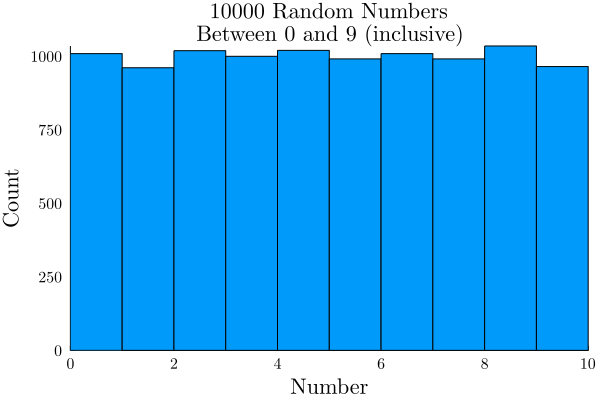

In [43]:
rnd = rand(0:9, 10^4)
p = histogram(rnd, xlim=(0, 10), ylim=(0, :auto), bins=10, grid=false,
    title="10000 Random Numbers\nBetween 0 and 9 (inclusive)", xlabel="Number", ylabel="Count",
    titlefontsize=14)

savefig(p, figpath * "rng-distribution.pdf")
display(p)

In [2]:
nmin, nmax, samples = 100, 10^6, 20

(100, 1000000, 20)

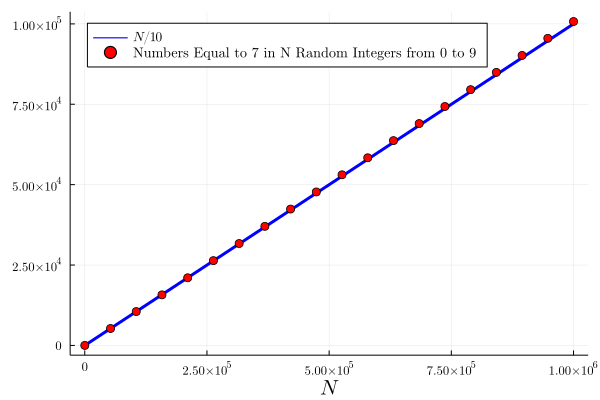

In [4]:
rnd = rand(0:9, nmax)
nlin = round.(Integer, range(nmin, nmax, length=samples))
rnd7 = [count(x->x==7, rnd[1:n]) for n in nlin]

p = plot(nlin, nlin./10, c=:blue, lw=3, label=L"N/10", xlabel=L"N", legend=:topleft,
    tickfontsize=8, legendfontsize=9, formatter=:scientific)
scatter!(p, nlin, rnd7, c=:red, ms=5, label="Numbers Equal to 7 in N Random Integers from 0 to 9")

savefig(p, figpath * "rng-growth.pdf")
display(p)

## Coefficient of Variation

In [16]:
runs = 10000
nlog = [round(Integer, ℯ^n) for n in range(log(nmin), log(nmax), length=samples)]
cvavg, cvσ = zeros(samples), zeros(samples)

for _ in 1:runs
    rnd = rand(0:9, nmax)
    cv = [std(count(==(i), rnd[1:n]) for i in 0:9) / n for n in nlog]

    cvavg += cv
    cvσ += cv.^2
end

cvavg ./= runs
# taking absolute value for small σ
cvσ = .√abs.(cvσ.^2 / runs - cvavg)

# save data to file
open("rng-cv.txt", "w") do io
    writedlm(io, [nlog cvavg cvσ])
end

In [53]:
# load data from file
data = readdlm("rng-cv.txt")
nlog, cvavg, cvσ = data[:, 1], data[:, 2], data[:, 3]

([100.0, 162.0, 264.0, 428.0, 695.0, 1129.0, 1833.0, 2976.0, 4833.0, 7848.0, 12743.0, 20691.0, 33598.0, 54556.0, 88587.0, 143845.0, 233572.0, 379269.0, 615848.0, 1.0e6], [0.030667965306609368, 0.024124991455926097, 0.018988334794641494, 0.01493332402924263, 0.011647637886452025, 0.009143100766474857, 0.007188413679714739, 0.005630483465091217, 0.004426253218728384, 0.0034691635464231107, 0.0027235496648055774, 0.0021447903949039747, 0.0016829902951951614, 0.0013174911101199334, 0.0010337024250679156, 0.0008089023703581692, 0.0006334082905768788, 0.0004995801094974418, 0.00039229841465253157, 0.00030780487578570465], [0.1441874992327853, 0.14263089248889427, 0.1324216192329142, 0.11990706274483735, 0.10696495417039985, 0.09521016978293272, 0.08460824339134167, 0.07496146094151435, 0.06649783727871719, 0.05888583384532818, 0.05218173270749166, 0.04630932438109371, 0.04102317206400164, 0.036296796082617995, 0.0321510445855243, 0.028441125066851248, 0.02516756824228041, 0.02235127321191712

In [50]:
nloglog, cvlog = log.(nlog), log.(cvavg)
exponent, coefficient = hcat(nloglog, ones(samples)) \ cvlog

error = √(sum(x->x^2, cvlog - exponent * nloglog .- coefficient) / (samples - 2)
    / sum(x->x^2, nloglog .- mean(nloglog)))
print(exponent, ' ', error)

-0.4875920981232614 0.017196332058198916

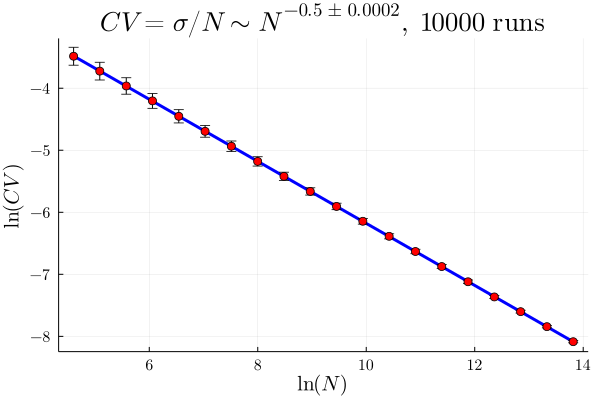

In [47]:
p = plot(x -> x * exponent + coefficient, nloglog, c=:blue, lw=3,
    xlabel=L"\mathrm{ln}(N)", ylabel=L"\mathrm{ln}(CV)",
    title="\$CV=\\sigma/N \\sim N^{$(round(exponent, digits=4)) \\pm $(round(error, sigdigits=1))},\\ "
    * "\\textrm{$runs \\ runs}\$")
scatter!(p, nloglog, cvlog, yerr=cvσ, c=:red, ms=5)

savefig(p, figpath * "rng-cv.pdf")
display(p)

## Numbers Coming Before 4 in a Series

In [74]:
function b4random(n::Integer)
    rnd = rand(0:9, n)
    # n / 10 numbers are expected and some extra space is allocated for fluctuations
    before4 = Vector{Integer}(undef, round(Integer, (3 / 20) * n))

    j = 1
    for i in 2:length(rnd)
        if rnd[i] == 4
            before4[j] = rnd[i - 1]
            j += 1
        end
    end
    return before4[1:j-1]
end

b4random (generic function with 1 method)

### Distribution

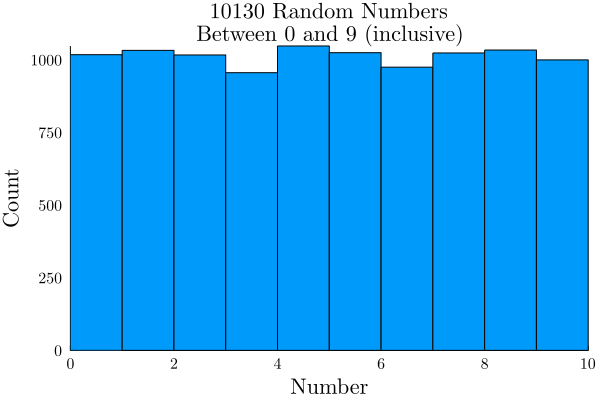

In [75]:
rnd = b4random(10^5)

p = histogram(rnd, xlim=(0, 10), ylim=(0, :auto), bins=10, grid=false,
    title="$(length(rnd)) Random Numbers\nBetween 0 and 9 (inclusive)",
    xlabel="Number", ylabel="Count", titlefontsize=14)

savefig(p, figpath * "rng-b4-distribution.pdf")
display(p)

In [83]:
nmin, nmax, samples = 100, 10^6, 20

(100, 1000000, 20)

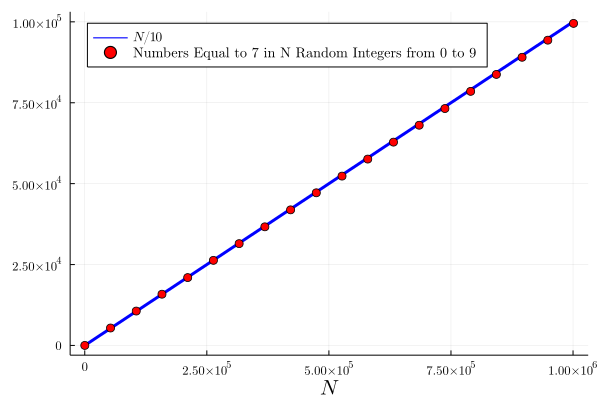

In [85]:
rnd = b4random(10 * nmax)

nlin = round.(Integer, range(nmin, length(rnd), length=samples))
rnd7 = [count(x->x==7, rnd[1:n]) for n in nlin]

p = plot(nlin, nlin./10, c=:blue, lw=3, label=L"N/10", xlabel=L"N", legend=:topleft,
    tickfontsize=8, legendfontsize=9)
scatter!(p, nlin, rnd7, c=:red, ms=5, label="Numbers Equal to 7 in N Random Integers from 0 to 9")

savefig(p, figpath * "rng-b4-growth.pdf")
display(p)

### Coefficient of Variation

In [90]:
runs = 10000
nlog = [round(Integer, ℯ^n) for n in range(log(nmin), log((9 / 10) * nmax), length=samples)]
cvavg, cvσ = zeros(samples), zeros(samples)

for _ in 1:runs
    rnd = b4random(10 * nmax)
    cv = [std(count(==(i), rnd[1:n]) for i in 0:9) / n for n in nlog]

    cvavg += cv
    cvσ += cv.^2
end

cvavg ./= runs
# taking absolute value for small σ
cvσ = .√abs.(cvσ.^2 / runs - cvavg)

# save data to file
open("rng-b4-cv.txt", "w") do io
    writedlm(io, [nlog cvavg cvσ])
end

In [91]:
# load data from file
data = readdlm("rng-b4-cv.txt")
nlog, cvavg, cvσ = data[:, 1], data[:, 2], data[:, 3]

([100.0, 161.0, 261.0, 421.0, 680.0, 1098.0, 1773.0, 2863.0, 4623.0, 7466.0, 12055.0, 19467.0, 31435.0, 50761.0, 81970.0, 132364.0, 213741.0, 345149.0, 557345.0, 900000.0], [0.030781787428878295, 0.02421118443053003, 0.019023540529292827, 0.01495290363092293, 0.0117619538394692, 0.009268285524999148, 0.007300845968828387, 0.005739626525155206, 0.00451289164994399, 0.0035405052756216507, 0.002784910177916758, 0.002200906808299127, 0.001729711872698866, 0.0013633216261574818, 0.0010753119680592398, 0.0008463801126848284, 0.0006661315125905951, 0.0005222898283517876, 0.000410663248596068, 0.00032281350224918715], [0.14407249235565306, 0.14278084202649963, 0.13251988631883121, 0.11997955061237037, 0.1074623775401193, 0.09584312800716992, 0.08525942841120064, 0.07568037949627084, 0.06714357160324676, 0.05948738501233477, 0.052765871349026036, 0.04691103178630053, 0.04158860286974871, 0.03692266209749596, 0.03279172187477088, 0.02909251392676981, 0.02580948100038004, 0.02285364296745359, 0.0

In [92]:
nloglog, cvlog = log.(nlog), log.(cvavg)
exponent, coefficient = hcat(nloglog, ones(samples)) \ cvlog

error = √(sum(x->x^2, cvlog - exponent * nloglog .- coefficient) / (samples - 2)
    / sum(x->x^2, nloglog .- mean(nloglog)))
print(exponent, ' ', error)

-0.5000821395521853 0.00016656704383822575

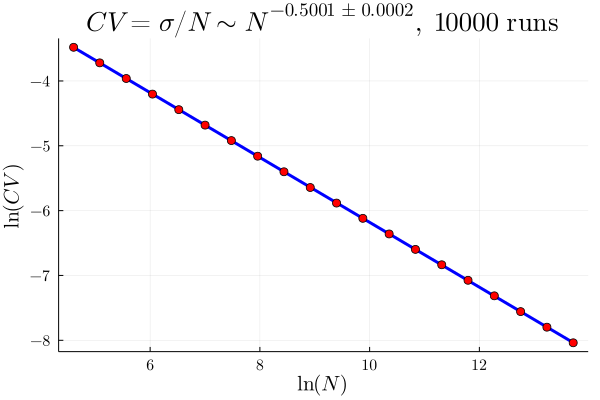

In [93]:
p = plot(x -> x * exponent + coefficient, nloglog, c=:blue, lw=3,
    xlabel=L"\mathrm{ln}(N)", ylabel=L"\mathrm{ln}(CV)",
    title="\$CV=\\sigma/N \\sim N^{$(round(exponent, digits=4)) \\pm $(round(error, sigdigits=1))},\\ "
    * "\\textrm{$runs \\ runs}\$")
scatter!(p, nloglog, cvlog, c=:red, ms=5)

savefig(p, figpath * "rng-b4-cv.pdf")
display(p)